# Trying OS Featuers (Min, 2nd, 3rd, ...)
Aka feature engineering by sorting

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score, KFold, train_test_split, RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import itertools
import lightgbm as lgb
import xgboost as xgb

In [5]:
DIRECTORY = './data/'
train = pd.read_csv(DIRECTORY + 'train.csv').drop(columns='id')
train.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,5,8,5,8,6,4,4,3,3,4,...,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,...,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,...,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,...,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


In [45]:
# 1. Sorted features
ordered = pd.DataFrame(
    np.sort(train.drop(columns='FloodProbability'), axis=1),
    columns=[f'order{i}' for i in range(1, 21)]
    )

# 2. Statistic aggregation features
statistics = pd.DataFrame({
    'mean': np.mean(ordered, axis=1),
    'std': np.std(ordered, axis=1),
    })

ordered = pd.concat([ordered, statistics], axis=1)

# 3. Grouped by same MEAN features
relevant_cols = [f'order{i}' for i in range(1, 21)] + ['std']
grouped = ordered.groupby(['mean'])[relevant_cols].mean().reset_index()
grouped = grouped.rename(columns={col: f'grouped_{col}' for col in grouped.columns})
ordered = ordered.merge(grouped, left_on='mean', right_on='grouped_mean')

# 4. Interaction terms (how does my col relate to the group)
for col in relevant_cols:
    ordered[f'difference_{col}'] = ordered[col] - ordered[f'grouped_{col}']

# 5. Count features
original_cols = [f'order{i}' for i in range(1, 21)]
for threshold in np.arange(1, 15):
    ordered[f'num_geq_{threshold}'] = (ordered[original_cols] >= threshold).sum(axis=1)
    ordered[f'num_leq_{threshold}'] = (ordered[original_cols] <= threshold).sum(axis=1)

ordered

,order1,order2,order3,order4,order5,order6,order7,order8,order9,order10,...,num_geq_10,num_leq_10,num_geq_11,num_leq_11,num_geq_12,num_leq_12,num_geq_13,num_leq_13,num_geq_14,num_leq_14
0,2,3,3,3,3,3,4,4,4,4,...,0,20,0,20,0,20,0,20,0,20
1,0,2,3,3,3,3,3,4,4,4,...,0,20,0,20,0,20,0,20,0,20
2,1,2,3,3,3,3,4,5,5,5,...,0,20,0,20,0,20,0,20,0,20
3,2,3,4,4,4,4,4,4,5,5,...,0,20,0,20,0,20,0,20,0,20
4,1,2,2,2,2,3,3,3,3,3,...,0,20,0,20,0,20,0,20,0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117952,1,2,2,3,3,3,4,4,4,4,...,2,20,0,20,0,20,0,20,0,20
1117953,1,2,2,3,3,3,4,4,4,4,...,0,20,0,20,0,20,0,20,0,20
1117954,1,2,3,3,4,4,4,5,5,5,...,0,20,0,20,0,20,0,20,0,20
1117955,2,3,3,3,3,4,4,4,4,5,...,0,20,0,20,0,20,0,20,0,20


In [46]:
X = ordered
y = train['FloodProbability']

scores = cross_val_score(
    xgb.XGBRegressor(n_jobs=-1, random_state=0),
    X, y, cv = 5, n_jobs=-1
)
print(F'{scores.mean():.5f} ± {scores.std():.5f}')  

KeyboardInterrupt: 

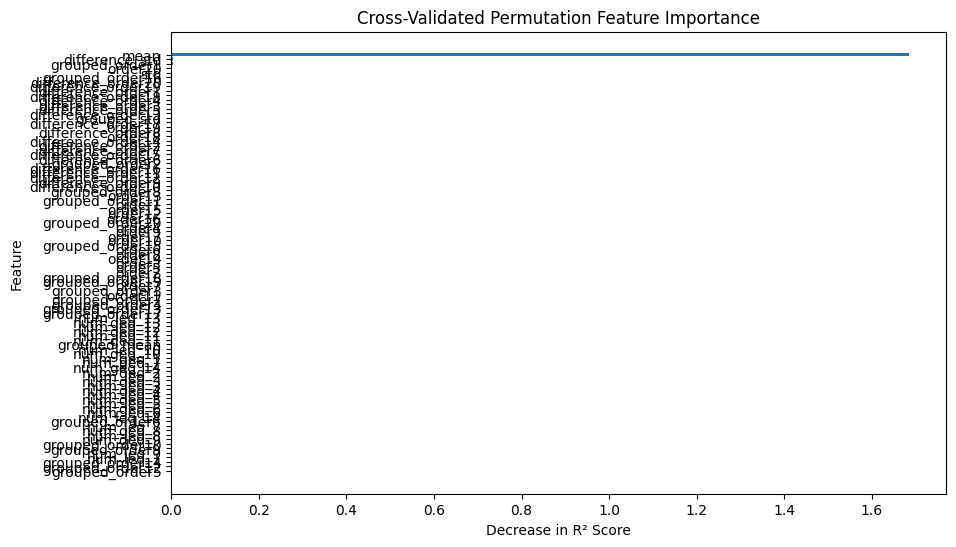

In [48]:
from sklearn.inspection import permutation_importance

kf = KFold(n_splits=5, shuffle=True, random_state=0)
importances = []

for train_idx, val_idx in list(kf.split(X))[:1]:
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Train model on training fold
    model = xgb.XGBRegressor(n_jobs=-1, random_state=0)
    model.fit(X_train, y_train)

    # Compute permutation importance on the validation fold
    result = permutation_importance(model, X_val, y_val, scoring="r2", n_repeats=10, random_state=0, n_jobs=-1)
    
    importances.append(result.importances_mean)

# Average importance across folds
importances = np.array(importances)
mean_importance = importances.mean(axis=0)
std_importance = importances.std(axis=0)

# Sort features by importance
sorted_idx = np.argsort(mean_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(np.array(X.columns)[sorted_idx], mean_importance[sorted_idx], xerr=std_importance[sorted_idx])
plt.xlabel("Decrease in R² Score")
plt.ylabel("Feature")
plt.title("Cross-Validated Permutation Feature Importance")
plt.show()


In [53]:
feature_importances = pd.DataFrame({
    'col': X.columns,
    'mean_importance': mean_importance,
    'std_importance': std_importance
    })

feature_importances.sort_values(by='mean_importance', ascending=False).head(20)

,col,mean_importance,std_importance
20,mean,1.685419,0.0
64,difference_std,0.003480,0.0
23,grouped_order1,0.002849,0.0
19,order20,0.002732,0.0
21,std,0.002257,0.0
38,grouped_order16,0.001113,0.0
63,difference_order20,0.001021,0.0
62,difference_order19,0.000560,0.0
44,difference_order1,0.000468,0.0
61,difference_order18,0.000445,0.0


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

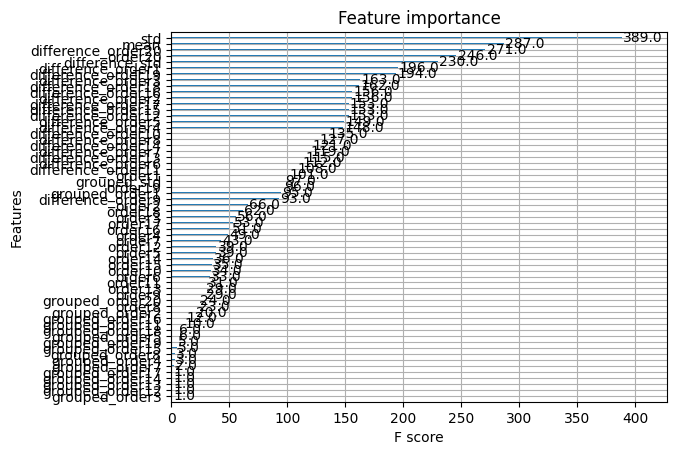

In [ ]:
xgb.plot_importance(model)